 **Kurze Erklärung zum Programm**

# Markowitz (Mean-Variance) Model

--- 

Hier stelle ich kurz das Grundliegende Model der Portfoliotheorie vor: Das Markowitz Model!


Wenn die Schwankung der täglichen Renditen verschiedener Aktien ungefähr Normal verteilt ist, kann man die Gewichtung so kombinieren das die Schwankung des Portfolios kleiner ist als die Schwakung der einzelnen Titel ("Minimumvarianzprinzip")

---




In [179]:
# Hier im ersten Block werden Libraries für die Berechnung des Portfolios importiert 

import decimal
import pandas as pd
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
import quandl
import matplotlib.pyplot as plt
# API configuration here
quandl.ApiConfig.api_key = "VAA5bZ67DimoDkvMStuG"
solvers.options['show_progress'] = False
import matplotlib.pyplot as plt

In [222]:
# Hier werden die Aktien oder Anleihen in einer Liste geladen
# stocklist und bond list muss klar unterschieden werden

stocklist = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB']

'''
stocklist = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB',
        'DHR', 'WYNN', 'PWR', 'ALGN', 'MU', 'CHTR', 'AVGO', 'CMA', 'NAVI', 'NUE', 'DLR', 'CNP', 'SYMC', 'RF',
        'MCHP', 'SYY', 'LRCX', 'FMC', 'ROST', 'TWX', 'MLM', 'STX', 'UNH', 'VTR', 'DRE', 'DGX', 'PLD', 'HP',
        'UAL', 'GLW', 'KEY', 'BBY', 'DE', 'CMI', 'WM', 'MGM', 'SNI', 'CFG', 'ZION', 'HAL', 'RSG', 'DRI', 'PKG']

'''

# A list of riskier stocks, (could be any other asset) to restrict the weights specifically

risklist = ['TIVO', 'JCP', 'F']

In [195]:
# Hier werden die Preise von der Quandl Datenbank gezogen

data = quandl.get_table('WIKI/PRICES', ticker = stocklist, 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
                        date = { 'gte': '2010-12-31', 'lte': '2017-12-31' }, 
                        paginate=True)

new = data.set_index('date')

# use pandas pivot function to sort adj_close by tickers
clean_data = new.pivot(columns='ticker')

# check the head of the output
#clean_data.head()



## In der nächsten Zeile können Sie die Modellparameter bestimmen 

---

**Wichtig ist das man das Maixmalgewicht nicht unterschreitet, da sonst die Gewichte in keinem Fall auf 100% kommen können und das das Programm eine Fehlermeldung wiedergibt**

Generell sollte das minimale und maximale Gewicht pro Wertpapier zwischen -1.0 und 1.0 liegen (-100% und 100%) 

---



In [209]:
# hier kann man die Modelparameter anpassen:

#Gewichtung im Model
Minimal_gewicht = -0.0
Maximal_gewicht = 1.0

#Scale of Optimization
Scale = 100 #usually set to 100

Riskaversion = 99 #have to figure out how to make it proportional to the Scale 

rf = 0.01 #risk-free rate for assets 

#historical data from beginning to end

#data_start = 
#data_end = 


x = decimal.Decimal(100/len(stocklist))
print("Achtung! das Maximale Gewicht (Maximal_gewicht) darf ", round(x,3) , "% nicht unterschreiten!")


Achtung! das Maximale Gewicht (Maximal_gewicht) darf  9.091 % nicht unterschreiten!


In [210]:
# here I will transform the data to be suitable for the model used

returnss = (clean_data.pct_change().dropna())
number = len(stocklist)


#clean_data.plot(figsize=(15, 10))
#print(returns.as_matrix)
returns = returnss.values #as_matrix()
print((returns.shape))



(543, 11)


In [229]:
def optimal_portfolio(returns):
    n = len(returns)
    #returns = np.diff(returns)
    returns = np.asmatrix(returns)
    
    G = Scale

    #G = 100
    mus = [10**(5.0 * t/G - 1.0) for t in range(G)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns)) #np.diff(returns1)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    
    # new constraint matrices for negative weights and weight adjustment
    dank = -np.array(np.eye(n))
    dabbie = np.array(np.eye(n))
    ye = np.vstack((dank, dabbie))
    deed = np.ones((2*n ,1))
    G = opt.matrix(ye, tc='d')
    #h = opt.matrix(deed, tc='d')
    #G = opt.matrix(np.r_[-np.eye(n), np.eye(n)], tc='d')
    #h = opt.matrix(np.r_[np.zeros((n,1)) +1 , np.zeros((n,1)) + 1], tc='d')
    
    d = -np.ones((n,1))*Minimal_gewicht #0.02
    e = np.ones((n,1))*Maximal_gewicht #0.050
    dodo = np.vstack((d, e))
    h = opt.matrix(dodo, tc='d')

        
    # Create constraint matrices do not uncomment G & H
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    #h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  (will add back later)
    returns = np.asarray([blas.dot(pbar, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, S*x)) for x in portfolios])
    
    
    ## Maximum Return Portfolio (will always return weights with 100% in asset with maximum mean return)
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt((m1[2])/ m1[0]) ##change for desired portfolio this solves for horizontal tangent portfolio (not now)
    maxr_opt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    
    ## approximates the position of the maximum Sharpe portfolio (also called tangent portfolio)
    slope = (returns-(rf/252))/risks
    sharpe_opt = slope.argmax()
    
    ## Minimum Variance Portfolio
    mini_var =  np.array(mus).max()
    minv_opt = solvers.qp(opt.matrix(mini_var * S), -pbar, G, h, A, b)['x']
    
    
    return np.asarray(maxr_opt), returns, risks, portfolios, sharpe_opt, mini_var

max_return_weights, returns, risk, weights, max_sharpe_weights, min_var_weights = optimal_portfolio(returns.T) #np.diff(returns1) returns3


Riskaversion =99
# index portfolios on the efficient frontier here
test1=np.array(opt.matrix(weights))
sublist=[test1[n:n+number] for n in range(0,len(test1),number)]
real=sublist[Riskaversion]


In [212]:
#show portfolio weights here, removing small weights

l = np.array(stocklist)
dic = {}
for i in range(len(stocklist)):
    dic[stocklist[i]] = real[i]

s = pd.Series(dic, index=stocklist)
df = s[abs(s) > 0.005]
df=df.astype(float)


AMD     0.155618
NVDA    0.145410
AMAT    0.081155
ALB     0.358163
FCX     0.179733
HPE     0.045540
IDXX    0.034381
dtype: float64


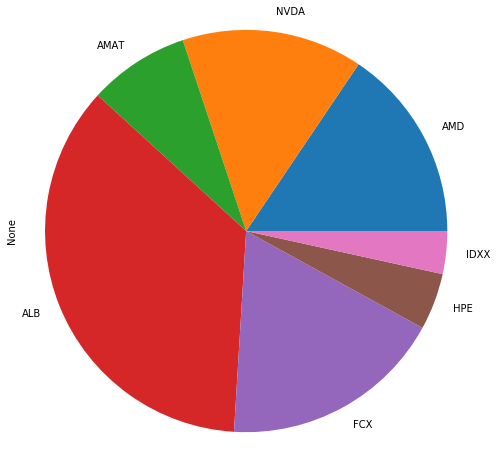

In [213]:
abs(df).plot.pie(y=None) 
plt.axis('equal')
print(df)

fig = plt.gcf()
fig.set_size_inches(8,8)


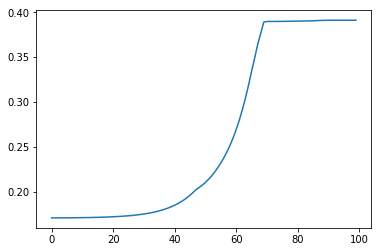

In [214]:
# risiko zu rendite 
t = Scale
scale = [t for t in range(t)] 
sclae = scale.reverse()
rendite = np.array(_)*100

plt.plot(scale,rendite)
#print(scale)

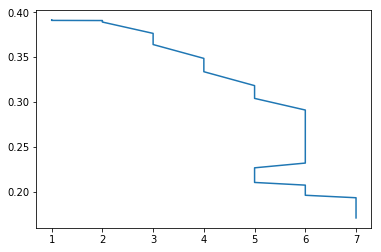

In [215]:
# relationship between number of assets in a portfolio (weighted more than 0.001) and return

def counting():
    count = []
    for lists in sublist:
        newlist = []
        for i in lists:
            if (i >= 0.02):
                newlist.append(i)
        count.append(len(newlist))
    return count
q = counting()



plt.plot(q, rendite)

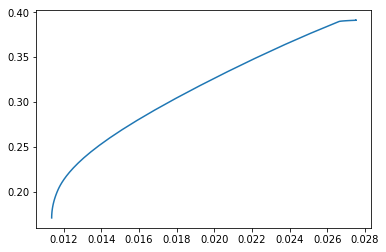

In [216]:
#classic markowitz bullet
plt.plot(risk, rendite)

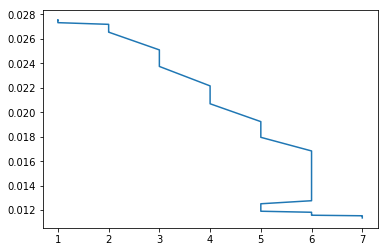

In [232]:
#risk and number of stocks in a portfolio
plt.plot(q, risk)

In [230]:
#I will write a function that will provide data in the correct format

stock = ['AAPL']

def datafunction(tickers):
    data = quandl.get_table('WIKI/PRICES', ticker = stock, 
                            qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
                            date = { 'gte': '2016-12-31', 'lte': '2017-12-31' }, 
                            paginate=True)
    new = data.set_index('date')
    # use pandas pivot function to sort adj_close by tickers
    clean_data = new.pivot(columns='ticker')
    return clean_data

    # check the head of the output
    #clean_data.head()

tryi = datafunction(stock)
print(tryi)

             adj_close
ticker            AAPL
date                  
2017-01-03  114.715378
2017-01-04  114.586983
2017-01-05  115.169696
2017-01-06  116.453639
2017-01-09  117.520300
2017-01-10  117.638817
2017-01-11  118.270913
2017-01-12  117.777088
2017-01-13  117.569682
2017-01-17  118.517825
2017-01-18  118.507948
2017-01-19  118.300542
2017-01-20  118.517825
2017-01-23  118.596837
2017-01-24  118.488195
2017-01-25  120.374604
2017-01-26  120.433863
2017-01-27  120.443739
2017-01-30  120.127692
2017-01-31  119.851150
2017-02-01  127.159749
2017-02-02  126.942467
2017-02-03  127.485673
2017-02-06  128.680728
2017-02-07  129.905412
2017-02-08  130.409113
2017-02-09  131.347379
2017-02-10  131.049809
2017-02-13  132.210332
2017-02-14  133.926319
...                ...
2017-11-16  171.100000
2017-11-17  170.150000
2017-11-20  169.980000
2017-11-21  173.140000
2017-11-22  174.960000
2017-11-24  174.970000
2017-11-27  174.090000
2017-11-28  173.070000
2017-11-29  169.480000
2017-11-30 